In [1]:
import fastai.vision.all
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import time

In [2]:
fastai.vision.all.URLs.CIFAR

'https://s3.amazonaws.com/fast-ai-sample/cifar10.tgz'

In [3]:
? fastai.vision.all.untar_data

Signature:
 fastai.vision.all.untar_data(
    url,
    archive=None,
    data=None,
    c_key='data',
    force_download=False,
)
Docstring: Download `url` to `fname` if `dest` doesn't exist, and extract to folder `dest`
File:      ~/.local/lib/python3.6/site-packages/fastai/data/external.py
Type:      function


In [4]:
path= fastai.vision.all.untar_data(fastai.vision.all.URLs.CIFAR)
path

Path('/home/akihikoy/.fastai/data/cifar10')

In [5]:
dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
                                    get_items=fastai.vision.all.get_image_files,
                                    get_y=fastai.vision.all.parent_label,
                                    item_tfms=fastai.vision.all.Resize(460),
                                    batch_tfms=fastai.vision.all.aug_transforms(size=224, min_scale=0.75) )
# dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
#                                     get_items=fastai.vision.all.get_image_files,
#                                     get_y=fastai.vision.all.parent_label )
dblock

In [30]:
dls= dblock.dataloaders(path, bs=64)
dls.n

48000

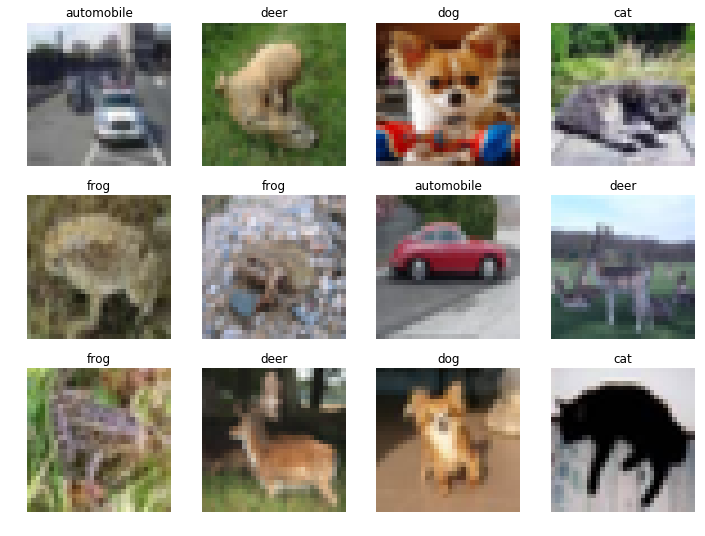

In [31]:
# x: Datasets
def show_grid(x, imgs, labels, ctxs=None, max_n=12, nrows=None, ncols=4, figsize=None, **kwargs):
    # if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = fastai.vision.all.get_grid(min(len(imgs), max_n), nrows=None, ncols=ncols, figsize=figsize)
    for ctx,img,label in zip(ctxs,imgs,labels):
        # x.show((img,label), ctx=ctx)
        i= img.clamp(0,1) if isinstance(img,torch.Tensor) else img
        t= x.vocab[label] if not isinstance(label,str) else str(label)
        fastai.vision.all.show_image(i, title=t, ctx=ctx, **kwargs)
b= dls.one_batch()
show_grid(dls, b[0], b[1])

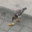

In [32]:
dls.dataset[0][0]

In [33]:
# Number of classes
dls.c, dls.vocab

(10,
 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

In [34]:
net= fastai.vision.all.xresnet18(n_out=dls.c, pretrained=True)
# net

In [35]:
learn= fastai.vision.all.Learner(dls, net, loss_func=fastai.vision.all.CrossEntropyLossFlat(), metrics=fastai.vision.all.accuracy)
learn

In [36]:
learn.summary()

XResNet (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 16 x 16   
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 16 x 16   
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128

In [14]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.057754,1.166360,0.598083,01:45


epoch,train_loss,valid_loss,accuracy,time
0,0.759133,1.068766,0.641500,01:45
1,0.574557,0.543875,0.816167,01:45
2,0.417555,0.406177,0.861000,01:45


SuggestedLRs(valley=0.0008317637839354575)

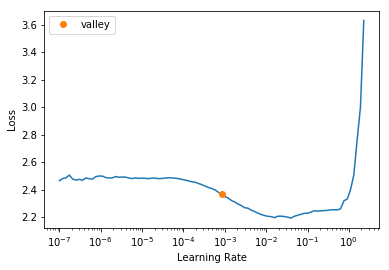

In [13]:
learn.lr_find()

In [37]:
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.926261,0.944556,0.661667,00:21
1,0.805283,0.911190,0.676333,00:20
2,0.665188,0.825809,0.709417,00:21
3,0.518695,0.664871,0.777333,00:20
4,0.370178,0.589231,0.802333,00:20
5,0.222844,0.609310,0.816333,00:20
6,0.106581,0.680125,0.829000,00:21
7,0.039145,0.769409,0.832583,00:21
8,0.012967,0.808443,0.835750,00:21
9,0.004421,0.796738,0.838167,00:22


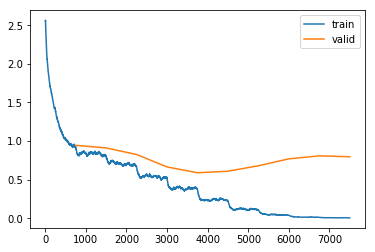

In [38]:
learn.recorder.plot_loss()

In [17]:
# learn.model.cpu()

true: ('airplane', TensorCategory(0))


predict: ('airplane', tensor(0), tensor([9.9303e-01, 2.4248e-06, 6.0790e-03, 5.5722e-06, 8.1490e-04, 6.9480e-07,
        2.9208e-07, 3.5109e-05, 2.5133e-05, 6.8692e-06]))


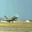

In [25]:
img= dls.dataset[1][0]
print(f'true: {dls.vocab[dls.dataset[1][1]], dls.dataset[1][1]}')
print(f'predict: {learn.predict(img)}')
img

In [26]:
fastai.vision.all.CrossEntropyLossFlat

fastai.losses.CrossEntropyLossFlat

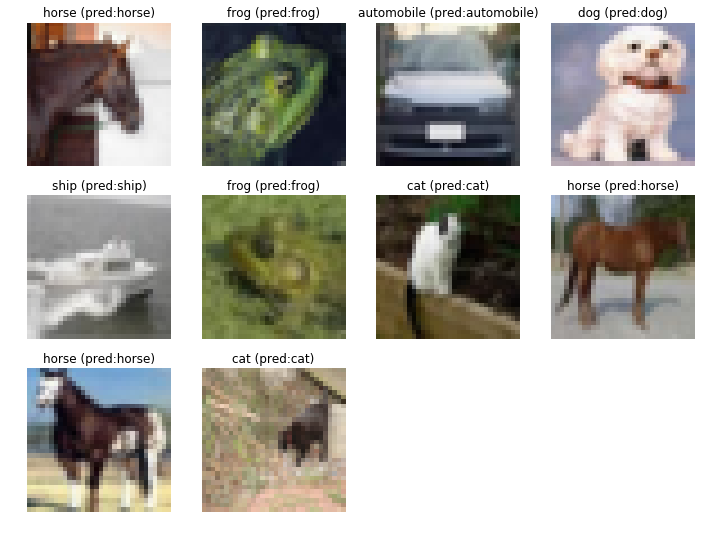

In [ ]:
b= dls.dataset[np.random.permutation(len(dls.dataset))[:10]]
# learn.show_results()
# learn.predict(b[0][0].cpu())
# learn.get_preds(dl=b[0].cpu())
# net.eval()
# with torch.no_grad():
#     net(b[0][0])
# print([learn.predict(b[0][i].cpu()) for i in range(len(b[0]))])
# show_grid(dls, b[0], [learn.predict(img.cpu())[1] for img in b[0]])
# print(len(b))
# print(b[0][1], b[0][0], learn.predict(b[0][0]))
# print(b[1][1], b[1][0], learn.predict(b[1][0]))
show_grid(dls, [img for img,label in b], [f'{dls.vocab[label]} (pred:{learn.predict(img)[0]})' for img,label in b])

In [21]:
#np.random.choice(dls.dataset, size=10)  #Do not use this.
dls.dataset[np.random.permutation(len(dls.dataset))[:10]]

[(PILImage mode=RGB size=32x32, TensorCategory(1)),
 (PILImage mode=RGB size=32x32, TensorCategory(1)),
 (PILImage mode=RGB size=32x32, TensorCategory(0)),
 (PILImage mode=RGB size=32x32, TensorCategory(0)),
 (PILImage mode=RGB size=32x32, TensorCategory(0)),
 (PILImage mode=RGB size=32x32, TensorCategory(9)),
 (PILImage mode=RGB size=32x32, TensorCategory(4)),
 (PILImage mode=RGB size=32x32, TensorCategory(5)),
 (PILImage mode=RGB size=32x32, TensorCategory(5)),
 (PILImage mode=RGB size=32x32, TensorCategory(6))]

# Comparison of data augmentation

## Without data augmentation (resnet18/pretrained model)

In [42]:
# dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
#                                     get_items=fastai.vision.all.get_image_files,
#                                     get_y=fastai.vision.all.parent_label,
#                                     item_tfms=fastai.vision.all.Resize(460),
#                                     batch_tfms=fastai.vision.all.aug_transforms(size=224, min_scale=0.75) )
dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
                                    get_items=fastai.vision.all.get_image_files,
                                    get_y=fastai.vision.all.parent_label )
dblock

In [44]:
dls= dblock.dataloaders(path, bs=64)
dls.n, dls.c, dls.one_batch()[0][0].shape

(48000, 10, torch.Size([3, 32, 32]))

In [45]:
net= fastai.vision.all.xresnet18(n_out=dls.c, pretrained=True)
learn= fastai.vision.all.Learner(dls, net, loss_func=fastai.vision.all.CrossEntropyLossFlat(), metrics=fastai.vision.all.accuracy)
learn.summary()

XResNet (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 16 x 16   
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 16 x 16   
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128

epoch,train_loss,valid_loss,accuracy,time
0,0.928276,0.994383,0.647250,00:22
1,0.810771,0.943390,0.676917,00:22
2,0.659985,0.954949,0.689833,00:22
3,0.512009,0.640550,0.785333,00:22
4,0.398057,0.602035,0.802917,00:22
5,0.220748,0.692430,0.804833,00:22
6,0.104962,0.734575,0.823833,00:22
7,0.040413,0.771946,0.835250,00:21
8,0.012025,0.796042,0.842917,00:21
9,0.005951,0.802151,0.842833,00:21


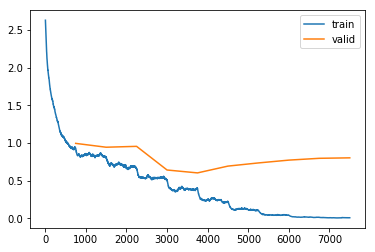

In [46]:
learn.fit_one_cycle(10, 3e-3)
learn.recorder.plot_loss()

## With data augmentation (resnet18/pretrained model); Best performance

In [6]:
dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
                                    get_items=fastai.vision.all.get_image_files,
                                    get_y=fastai.vision.all.parent_label,
                                    item_tfms=fastai.vision.all.Resize(460),
                                    batch_tfms=fastai.vision.all.aug_transforms(size=224, min_scale=0.75) )
dblock

In [7]:
dls= dblock.dataloaders(path, bs=64)
dls.n, dls.c, dls.one_batch()[0][0].shape

/home/akihikoy/.local/lib/python3.6/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


(48000, 10, torch.Size([3, 224, 224]))

In [8]:
net= fastai.vision.all.xresnet18(n_out=dls.c, pretrained=True)
learn= fastai.vision.all.Learner(dls, net, loss_func=fastai.vision.all.CrossEntropyLossFlat(), metrics=fastai.vision.all.accuracy)
learn.summary()

/home/akihikoy/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


XResNet (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 112 x 112 
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 112 x 112 
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128

epoch,train_loss,valid_loss,accuracy,time
0,1.097620,1.304630,0.542667,01:44
1,0.873547,1.116138,0.631333,01:44
2,0.664199,0.801870,0.731333,01:44
3,0.518736,0.691537,0.773417,01:43
4,0.434849,0.505543,0.831667,01:43
5,0.334140,0.337891,0.883083,01:43
6,0.282051,0.326555,0.889250,01:44
7,0.199081,0.250719,0.912667,01:43
8,0.166040,0.231042,0.918917,02:26
9,0.151991,0.227370,0.921833,03:16


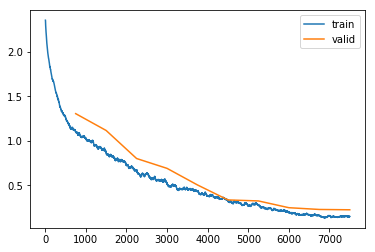

In [9]:
learn.fit_one_cycle(10, 3e-3)
learn.recorder.plot_loss()